<a href="https://colab.research.google.com/github/shkim123123/201920947/blob/main/F2_%EA%B9%80%EC%8A%B9%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks
import numpy as np
import matplotlib.pyplot as plt


--2024-06-14 01:36:29--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-06-14 01:36:29 (55.7 MB/s) - ‘utils.py’ saved [771/771]



In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

In [22]:
from scipy.stats import norm
from notebooks.utils import display

IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

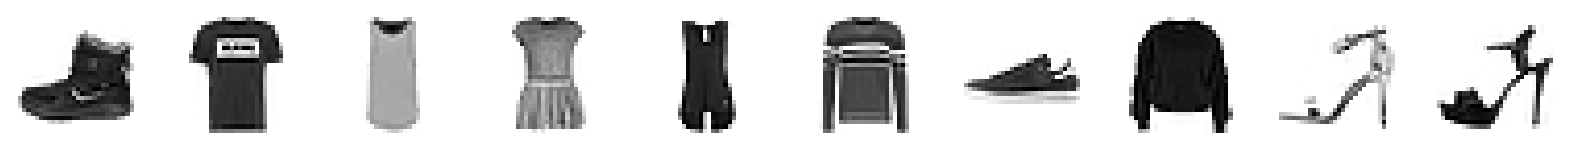

In [23]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# 데이터 전처리
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# 훈련 세트의 일부 의류 항목 표시
display(x_train)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [24]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

In [25]:
# 디코더
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

In [26]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=True,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 [==============================] - ETA: 0s - total_loss: 161.9707 - reconstruction_loss: 157.5584 - kl_loss: 4.4122

600/600 [==============================] - 10s 12ms/step - total_loss: 161.9707 - reconstruction_loss: 157.5584 - kl_loss: 4.4122 - val_loss: 142.4573 - val_reconstruction_loss: 137.5096 - val_kl_loss: 4.9476
Epoch 2/5
596/600 [============================>.] - ETA: 0s - total_loss: 136.3112 - reconstruction_loss: 131.2888 - kl_loss: 5.0223

600/600 [==============================] - 6s 10ms/step - total_loss: 136.3117 - reconstruction_loss: 131.2880 - kl_loss: 5.0236 - val_loss: 138.3011 - val_reconstruction_loss: 133.0939 - val_kl_loss: 5.2073
Epoch 3/5
597/600 [============================>.] - ETA: 0s - total_loss: 134.4570 - reconstruction_loss: 129.3898 - kl_loss: 5.0671

600/600 [==============================] - 6s 10ms/step - total_loss: 134.4787 - reconstruction_loss: 129.4118 - kl_loss: 5.0669 - val_loss: 137.7975 - val_reconstruction_loss: 132.5232 - val_kl_loss: 5.2744
Epoch 4/5
595/600 [============================>.] - ETA: 0s - total_loss: 133.4938 - reconstruction_loss: 128.3718 - kl_loss: 5.1220

600/600 [==============================] - 6s 11ms/step - total_loss: 133.4995 - reconstruction_loss: 128.3781 - kl_loss: 5.1214 - val_loss: 135.9783 - val_reconstruction_loss: 130.7179 - val_kl_loss: 5.2605
Epoch 5/5
598/600 [============================>.] - ETA: 0s - total_loss: 132.8503 - reconstruction_loss: 127.6603 - kl_loss: 5.1899

600/600 [==============================] - 7s 11ms/step - total_loss: 132.8476 - reconstruction_loss: 127.6582 - kl_loss: 5.1894 - val_loss: 135.3341 - val_reconstruction_loss: 130.2974 - val_kl_loss: 5.0367


In [27]:
# 최종 모델 저장
vae.save_weights("./models/vae_weights")
encoder.save_weights("./models/encoder_weights")
decoder.save_weights("./models/decoder_weights")


In [28]:
# 모델 로드 후 컴파일
vae.load_weights("./models/vae_weights")
encoder.load_weights("./models/encoder_weights")
decoder.load_weights("./models/decoder_weights")
vae.compile(optimizer=optimizer)


In [29]:
# 잠재 공간의 지정된 값으로부터 이미지 생성
latent_points = np.array([
    [0.234, 0.342],
    [0.419, 0.904],
    [0.756, 0.547],
    [0.865, 0.456]
])


In [30]:
# 디코더를 사용하여 이미지를 생성
generated_images = decoder.predict(latent_points)


1/1 [==============================] - 0s 246ms/step


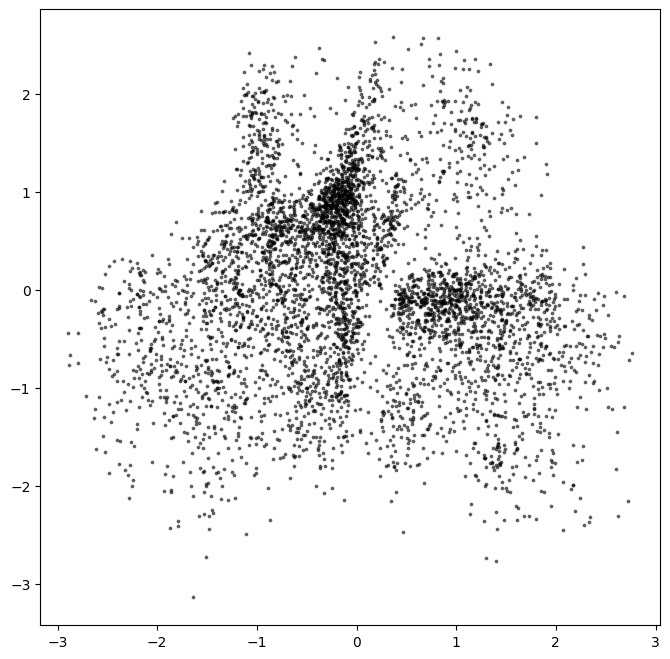

1/1 [==============================] - 0s 273ms/step


In [13]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)
# 원본 임베딩과 샘플링된 임베딩을 p값으로 변환하기
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

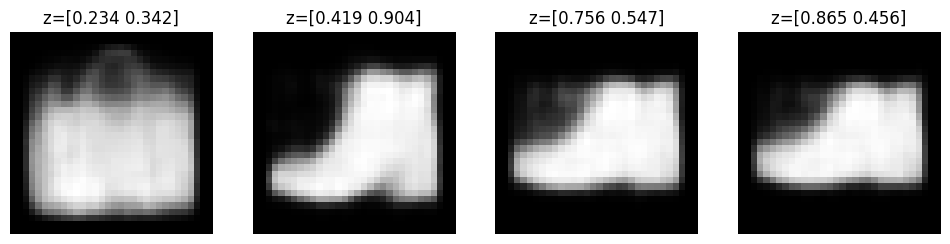

In [31]:
# 생성된 이미지 시각화
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, img in enumerate(generated_images):
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"z={latent_points[i]}")

plt.show()

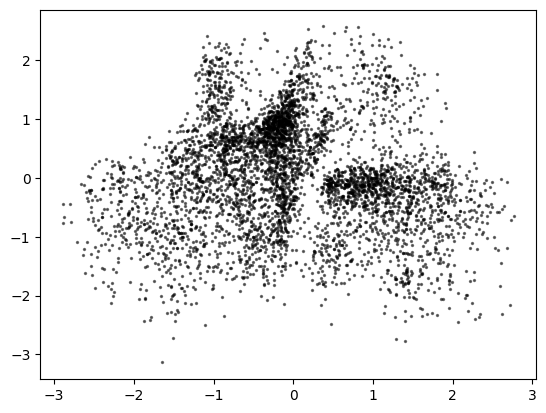

In [15]:
# ... 원본 임베딩 ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

In [17]:
# ... 잠재 공간에 새로 생성된 포인트
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha

SyntaxError: incomplete input (<ipython-input-17-39882505cac4>, line 2)